In [1]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines.common.env_checker import check_env
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy

import numpy as np
from ads_utils import load_data, plot, Environment

from tqdm import tqdm

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



https://github.com/notadamking/Stock-Trading-Environment/blob/master/env/StockTradingEnv.py
The code follows some of this implementation. 


In [2]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 5
        
'''NOTE: there is no train/test split yet'''            
data = load_data([2])

fake = np.linspace(100, 200, len(data))
data['close'] = fake

env = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS) ########################### PAST_TICKS
env

Balance: $10000, Price: $100.06, Position: 1

In [3]:
# It will check your custom environment and output additional warnings if needed
check_env(env)
env.reset()

array([100.01943068, 100.02914602, 100.03886136, 100.0485767 ,
       100.05829204,   1.        ])

The model used is PPO2 

#### Short excerpt from docs: 
The Proximal Policy Optimization (PPO) algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).

#### Link to doc:
https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html

* there's other actor-critic based models to implement as well


PS: I have yet to know how to interpret the results below

In [4]:
model = PPO2(MlpPolicy, env, verbose=1)

model.learn(total_timesteps=1000) 

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



--------------------------------------
| approxkl           | 0.0001330573  |
| clipfrac           | 0.0           |
| explained_variance | -1.38e-05     |
| fps                | 213           |
| n_updates          | 1             |
| policy_entropy     | 1.0983088     |
| policy_loss        | 0.00040887413 |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 128           |
| value_loss         | 0.80581874    |
--------------------------------------
--------------------------------------
| approxkl           | 0.00013442311 |
| clipfrac           | 0.0           |
| explained_variance | 3.78e-05      |
| fps                | 850           |
| n_updates          | 2 

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1726.47it/s]


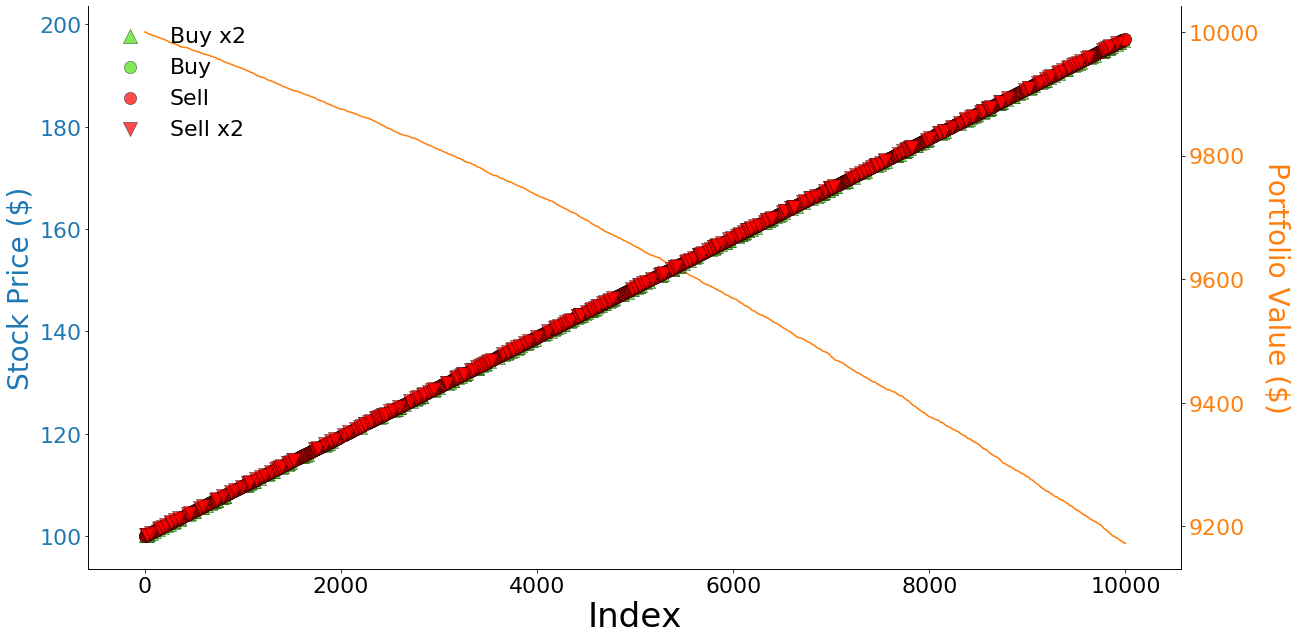

In [5]:
state = env.reset()

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(10000)):
    action, _ = model.predict(state)
    
    price, portfolio_value = env.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    state, reward, done, _ = env.step(action)
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

In [358]:
# Base code sourced from https://github.com/shivaverma/OpenAIGym/blob/master/lunar-lander/discrete/lunar_lander.py

import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np
env = Environment(data.close.to_list(), INITIAL_BALANCE)
env.seed(0)
np.random.seed(0)

class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space, γ=0.9, ε_decay=0.9995):

        self.action_space = action_space
        self.state_space = state_space
        self.ε = 1.0
        self.γ = γ
        self.batch_size = 32
        self.ε_min = 0.01
        self.lr = 0.0005
        self.ε_decay = ε_decay
        self.memory = deque(maxlen=10_000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(100, input_dim=self.state_space, activation=relu))
        model.add(Dense(100, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) ###############################################

    def get_action(self, state, exploit=False):

        if np.random.rand() + int(exploit) <= self.ε:
            return random.randrange(self.action_space)
        action_values = self.model.predict(state)
        return np.argmax(action_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states      = np.array([i[0] for i in batch])
        actions     = np.array([i[1] for i in batch])
        rewards     = np.array([i[2] for i in batch])
        next_states = np.array([i[3] for i in batch])
        dones       = np.array([i[4] for i in batch])
        
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.γ*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0) ###############################################
        if self.ε > self.ε_min:
            self.ε *= self.ε_decay

def train_dqn(agent, env, episodes):

    rewards = []
    for e in tqdm(range(episodes)):
        state = env.reset(rand_start=True)
        state = np.reshape(state, (1, 6))
        score = 0
        max_steps = 2_000
        for i in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 6))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
            agent.replay()
                
            if done:
                #print("episode: {}/{}, score: {}".format(e, episodes, score))
                break
        rewards.append(score)

    return rewards

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.06s/it]


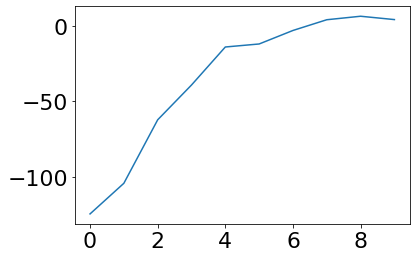

In [63]:
from tqdm import tqdm
fake = np.linspace(100, 200, len(data))
data['close'] = fake

env = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
episodes = 10
agent = DQN(env.action_space.n, env.observation_space.shape[0])
loss = train_dqn(agent, env, episodes=10)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1680.15it/s]


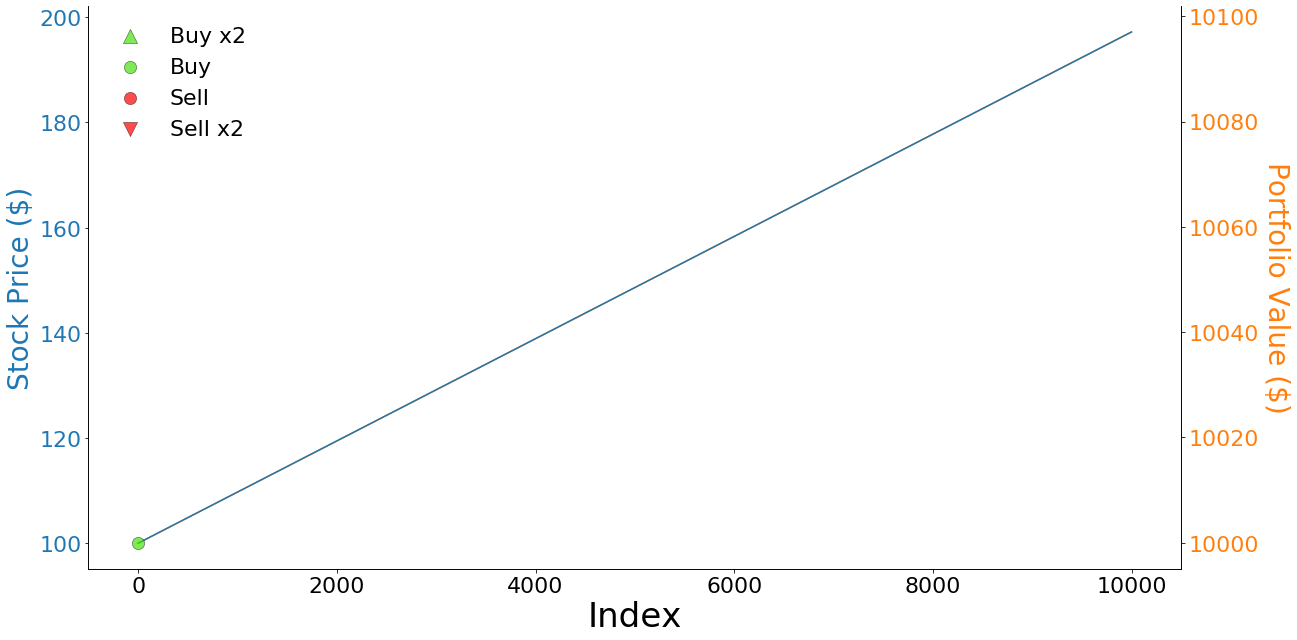

In [64]:
state = env.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
n_ticks = 10000
for i in tqdm(range(n_ticks)):
    action = agent.get_action(state, exploit=True)
    
    price, portfolio_value = env.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.37s/it]


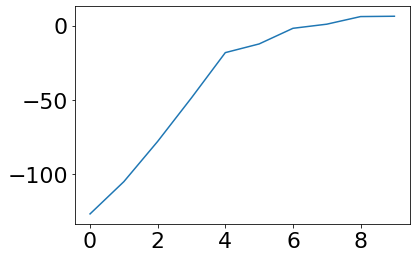

In [66]:
fake = np.linspace(200, 100, len(data))
data['close'] = fake

env2 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent2 = DQN(env2.action_space.n, env2.observation_space.shape[0])
loss = train_dqn(agent2, env2, episodes=10)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2014.10it/s]


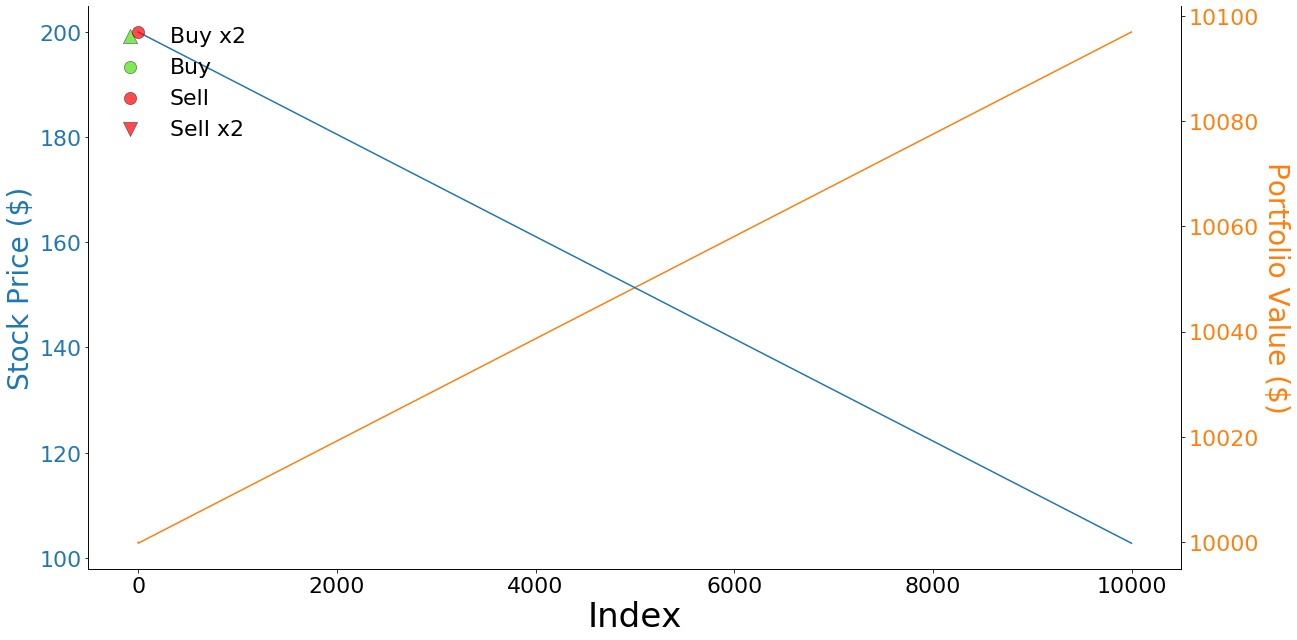

In [67]:
state = env2.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(n_ticks)):
    action = agent2.get_action(state, exploit=True)
    
    price, portfolio_value = env2.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env2.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.46s/it]


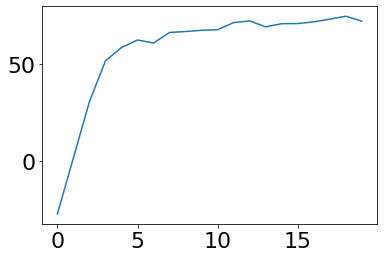

In [360]:
fake = 10*np.sin(np.linspace(0, 3141.592, len(data))/50) + 20
data['close'] = fake

env3 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent3 = DQN(env3.action_space.n, env3.observation_space.shape[0])
loss = train_dqn(agent3, env3, episodes=20)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

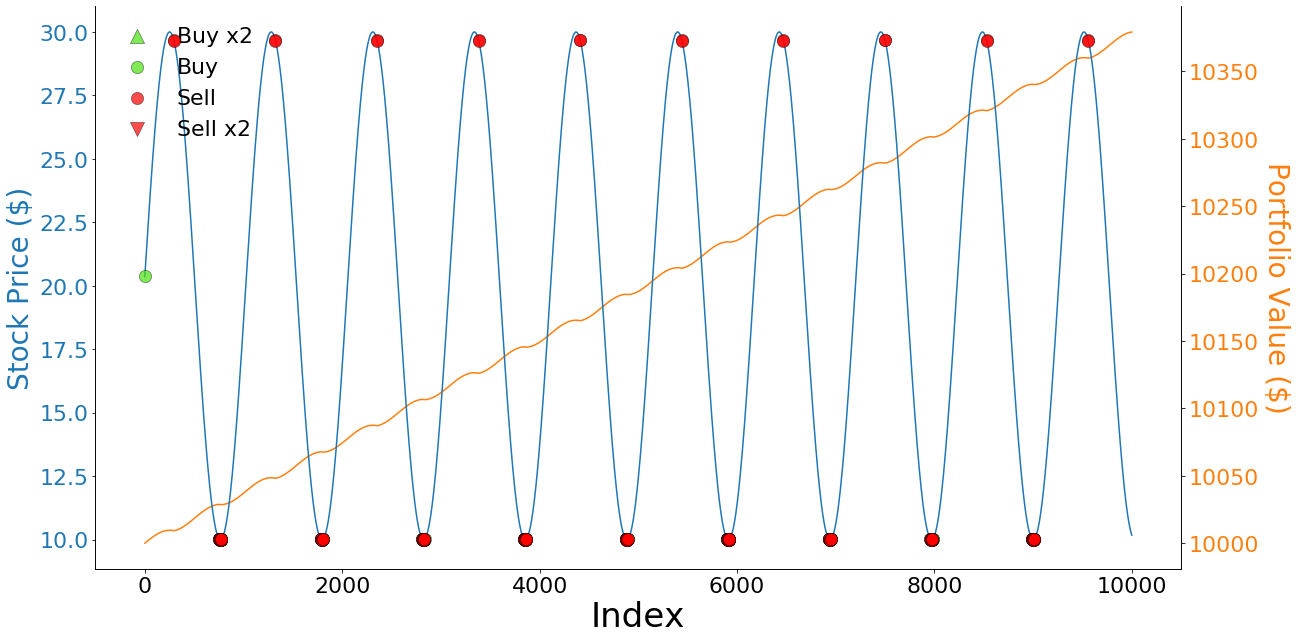

In [361]:
state = env3.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in range(n_ticks):
    action = agent3.get_action(state, exploit=True)
    
    price, portfolio_value = env3.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env3.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.38s/it]


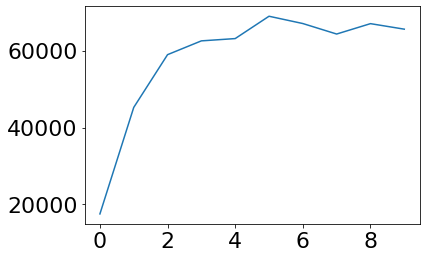

In [362]:
fake = 100*np.sin(np.linspace(0, 3141.592, len(data))/50) + np.random.normal(1000, 50, len(data))
data['close'] = fake

env4 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent4 = DQN(env4.action_space.n, env4.observation_space.shape[0])
loss = train_dqn(agent4, env4, episodes=episodes)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1779.89it/s]


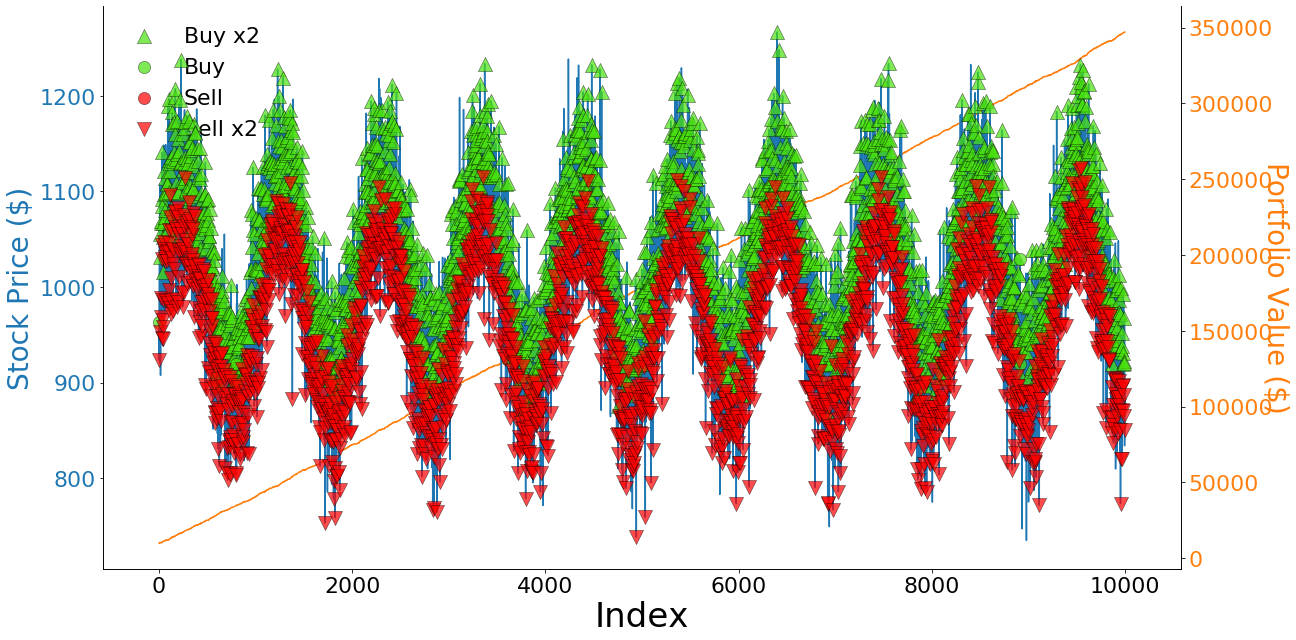

In [365]:
state = env4.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(10)):
    action = agent4.get_action(state, exploit=True)
    
    price, portfolio_value = env4.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env4.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, [0] + actions[:-1], portfolio_values, right_y_adjust=1.1)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:09<00:00,  1.25s/it]


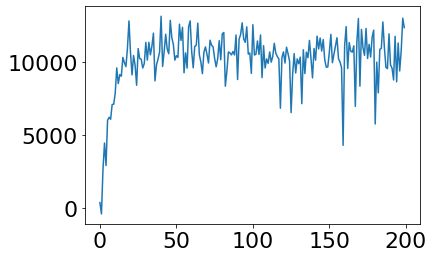

In [51]:
fake = np.random.normal(1000, 50, len(data))
data['close'] = fake

env5 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent5 = DQN(env5.action_space.n, env5.observation_space.shape[0])
loss = train_dqn(agent5, env5, episodes=episodes)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

 97%|█████████████████████████████████████████████████████████████████████████  | 9739/10000 [00:04<00:00, 2245.85it/s]


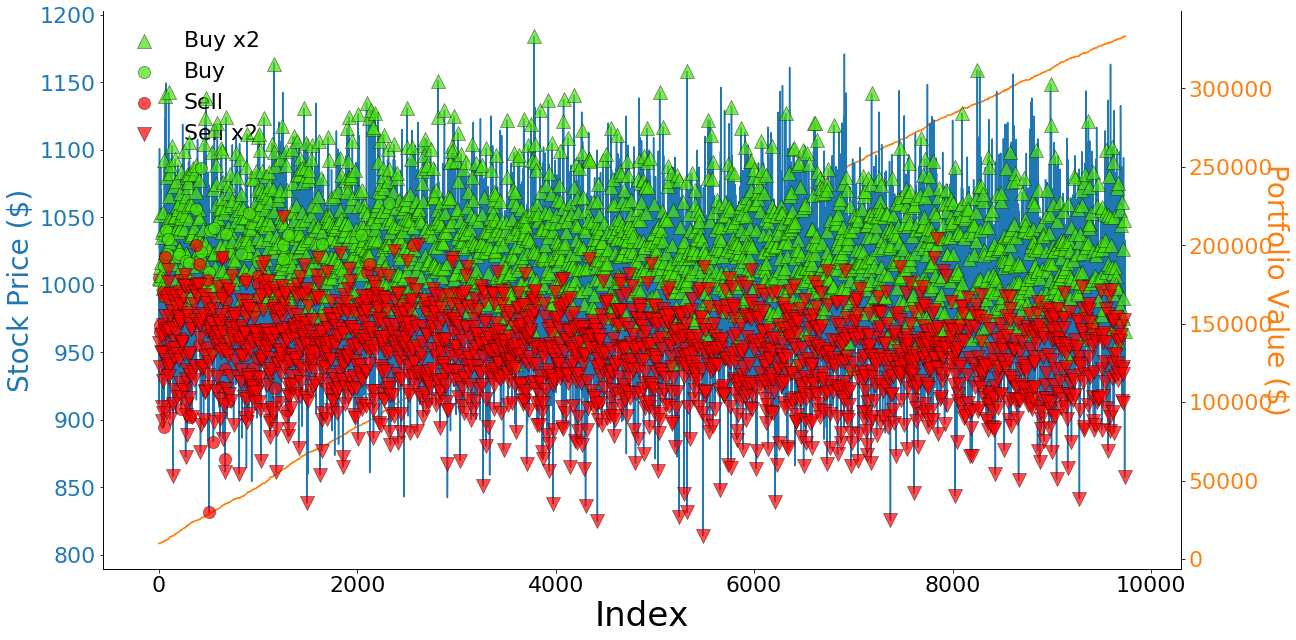

In [57]:
state = env5.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(n_ticks)):
    action = agent5.get_action(state, exploit=True)
    
    price, portfolio_value = env5.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env5.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:23<00:00,  1.32s/it]


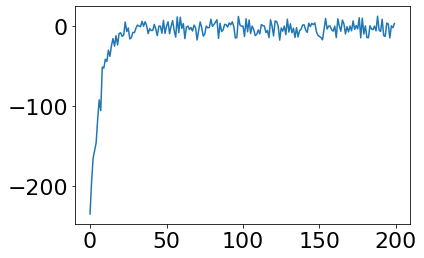

In [58]:
fake = 1000 - np.abs(np.arange(0, len(data)) - len(data)/2) * 0.05
data['close'] = fake

env6 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent6 = DQN(env6.action_space.n, env6.observation_space.shape[0])
loss = train_dqn(agent6, env6, episodes=episodes)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

 84%|██████████████████████████████████████████████████████████████▉            | 8398/10000 [00:03<00:00, 2128.14it/s]


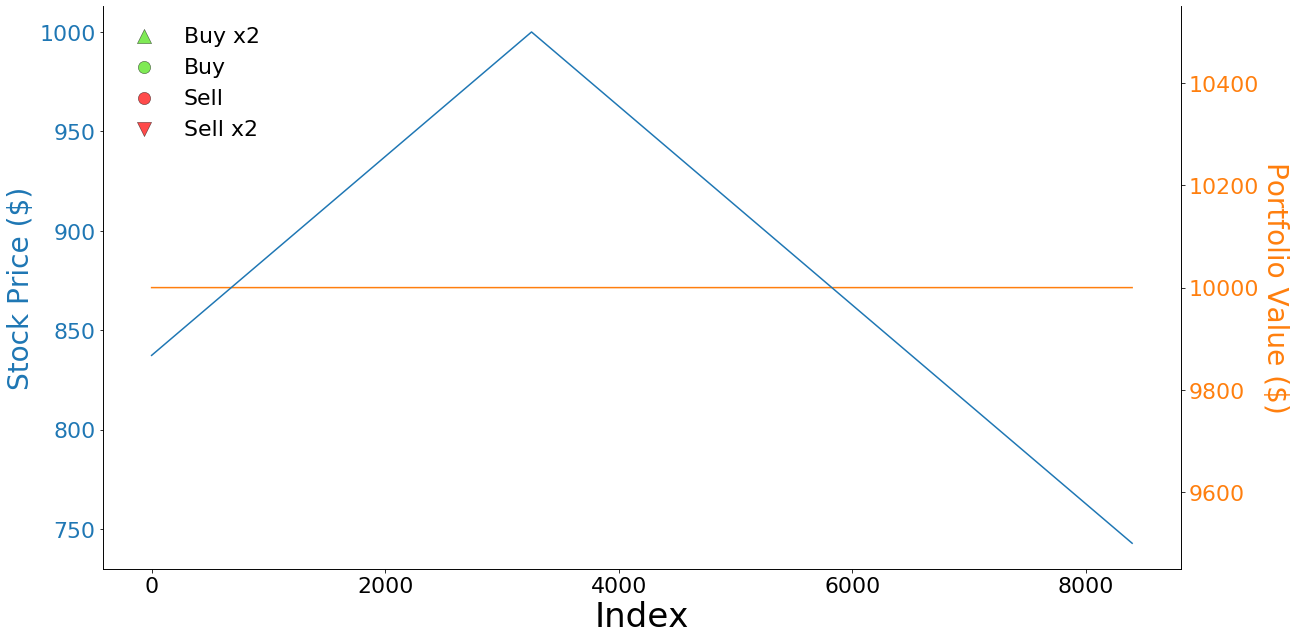

In [61]:
state = env6.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(n_ticks)):
    action = agent6.get_action(state, exploit=True)
    
    price, portfolio_value = env6.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env6.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:11<00:00,  1.26s/it]


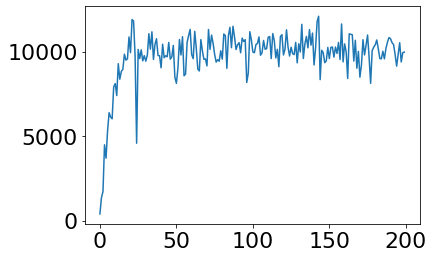

In [62]:
fake = np.random.normal(1000, 50, len(data)) - np.abs(np.arange(0, len(data)) - len(data)/2) * 0.05
data['close'] = fake

env7 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent7 = DQN(env7.action_space.n, env7.observation_space.shape[0])
loss = train_dqn(agent7, env7, episodes=episodes)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

 79%|███████████████████████████████████████████████████████████▎               | 7910/10000 [00:03<00:00, 2264.49it/s]


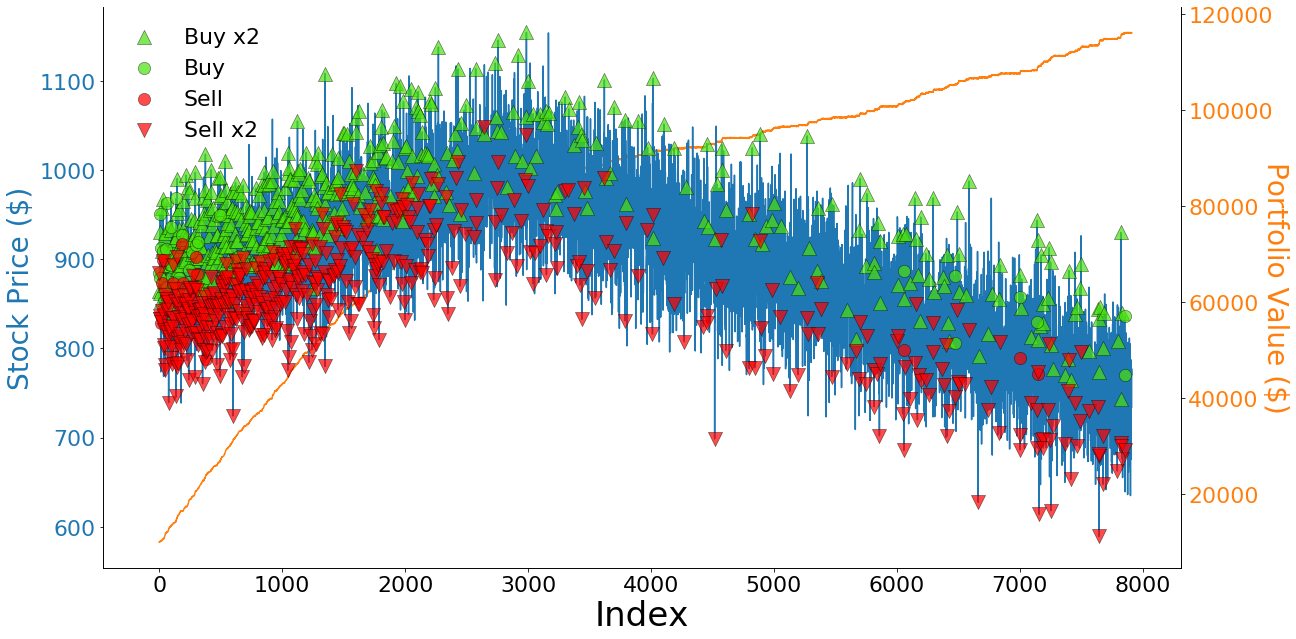

In [74]:
state = env7.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(n_ticks)):
    action = agent7.get_action(state, exploit=True)
    
    price, portfolio_value = env7.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env7.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


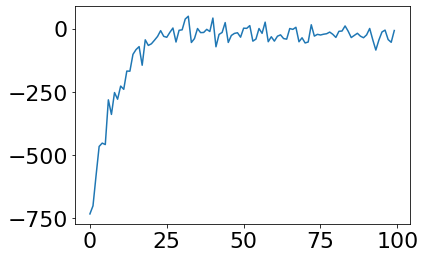

In [19]:
data = load_data([2])

env8 = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
agent8 = DQN(env8.action_space.n, env8.observation_space.shape[0])
loss = train_dqn(agent8, env8, episodes=episodes)
plt.plot(np.arange(0, len(loss)), loss)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2909.40it/s]


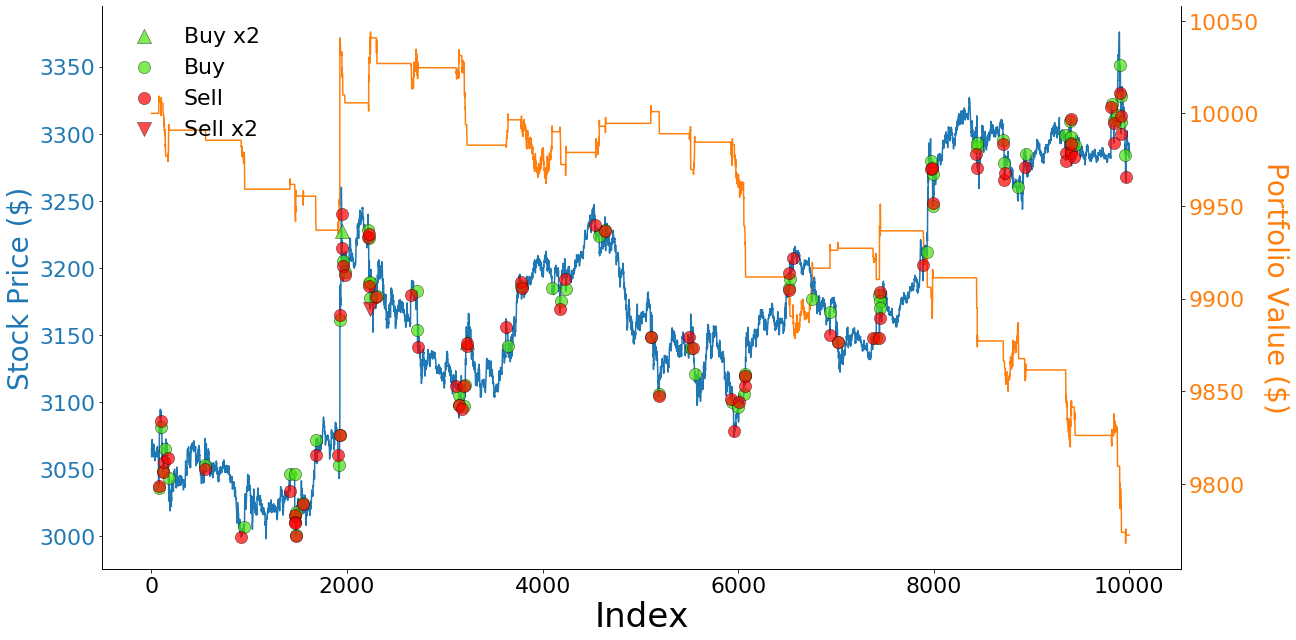

In [20]:
state = env8.reset()
state = np.reshape(state, (1, 6))

portfolio_values = []
prices = []
actions = []
for i in tqdm(range(n_ticks)):
    action = agent8.get_action(state, exploit=True)
    
    price, portfolio_value = env8.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)
    
    next_state, reward, done, _ = env8.step(action)
    next_state = np.reshape(next_state, (1, 6))
    state = next_state
    
    if done:
        break

plot(prices, actions, portfolio_values, right_y_adjust=1.1)